# Import Modules

In [1]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
from datetime import datetime, timedelta
import json
from multiprocessing import Pool, Manager
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Process the Output

Multiple weather data files were generated as the data collection was run in two batches. Therefore, they required joining first.

In [4]:
# Function to read text files as json
def read_txt_as_df(filepath):
    rows = []
    with open(filepath, 'r+') as f:
        for line in f:
            try: 
                data = json.loads(line)
                if isinstance(data, dict):
                    rows.append(data)
            except json.JSONDecodeError:
                continue

    # Convert to a dataframe
    df = pd.DataFrame(rows)
    return df

In [6]:
# Filepaths to weather data in a given location
filepath = "../data/raw_satellite_and_weather/20250611_openmeteo_weather.txt"
second_filepath = "../data/modelling/baseline_datasets/20250630_openmeteo_weather.txt"

wdf1 = read_txt_as_df(filepath)
wdf2 = read_txt_as_df(second_filepath)

In [7]:
# Merge dataframes 
merged = pd.concat([wdf1, wdf2])

print(f"Length of first df: {len(wdf1)}")
print(f"Length of second df: {len(wdf2)}")
print(f"Length of merged df: {len(merged)}")

# Unique point IDs:
print(f"Number of unique Point IDs: {merged['point_id'].nunique()}")

Length of first df: 573408
Length of second df: 936
Length of merged df: 574344
Number of unique Point IDs: 15954


In [ ]:
## FOR RUNNING COLLECTION AGAIN - CHECKING WHICH POINT IDs HAVE BEEN COLLECTED

# with open('./data/raw/soil_ids_done_weather.txt', 'w') as f:
#     ids_todo = wthr[wthr['image_id'].isnull()]['point_id'].unique().tolist()
#     ids_done = merged['point_id'].unique().tolist()
#     for item in ids_done:
#         f.write(f"{item}\n")

In [8]:
# Remove rows with null values
merged = merged[~merged.isnull().any(axis=1)]

In [9]:
# Remove columns which are not needed:
cols_to_remove = ['sunrise'] # Sunrise is the same value for every columm
merged = merged.drop(columns=cols_to_remove, errors='ignore')

## Identify Correlations

### Load Soil Data and Merge with the Weather Data

In [10]:
soil = pd.read_csv("../data/modelling/baseline_datasets/processed/20250711_lucas_cleaned.csv")
soil = soil.rename(columns={'SURVEY_DATE': 'survey_date',
                            'POINTID': 'point_id'})
soil['survey_date'] = pd.to_datetime(soil['survey_date'])

In [11]:
# Select LUCAS columns to keep
cols_to_use = ['point_id', 
               'log_OC',
               'log_N', 
               'survey_date', 
               'Elev', 'LC0_Desc', 'LU1_Desc', 
               'parcel_area_ha', 'crop_residues', 'lm_grass_margins', 'grazing',
               'LC1_Grouped',
               'soil_stones_perc', 
            #    'OC', 'N', 
            #    'LC1_Desc', 
            #    'gps_lat', 'gps_long', 
            #    'lc1_perc',
            #    'country_name', 
            #    'coord_tuple', 
            #    'geometry', 
            #    'log_OC_scaled', 'log_N_scaled',
               ]
soil = soil[cols_to_use]

In [12]:
# Convert date cols to correct format
merged['survey_date'] = pd.to_datetime(merged['survey_date'])
merged['date'] = pd.to_datetime(merged['date'])

In [13]:
# Merge the LUCAS dataframe with the weather data
df = soil.merge(merged, how="right", on=['point_id', 'survey_date'])

## Select Weather Data from the same day as the survey date

In [14]:
dayof = df[df['date'] == df['survey_date']]
print(f"Length of dataframe: {len(dayof)}")

Length of dataframe: 15954


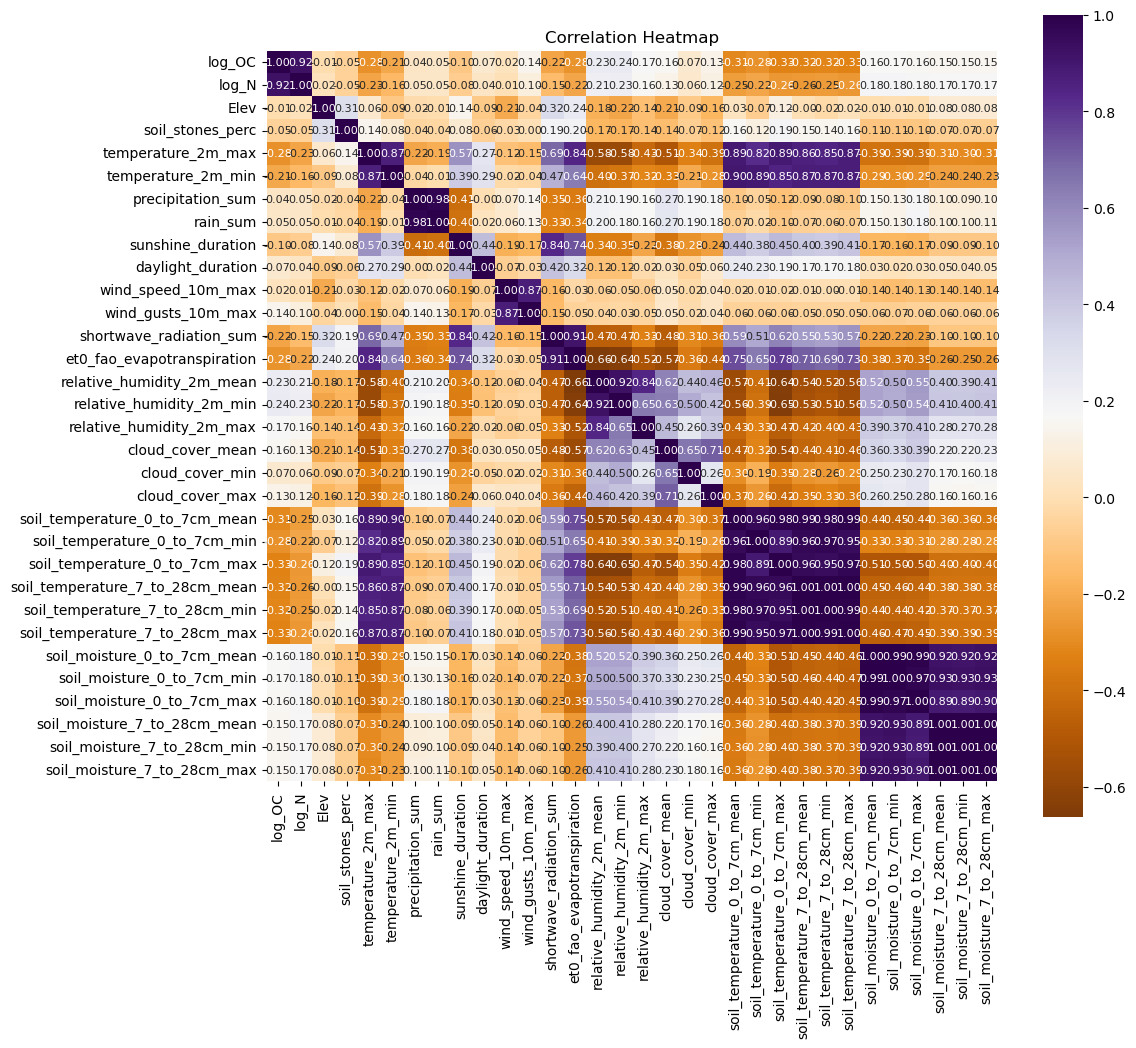

In [15]:
num_cols = dayof.select_dtypes(include=np.number).columns.tolist()
corr_features = [col for col in num_cols if col not in ['point_id', 'survey_date', 'date']]
corr_df = dayof[corr_features]
# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot as heatmap
plt.figure(figsize=(12, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            # mask=mask, 
            annot=True, cmap='PuOr', fmt=".2f", square=True,
            cbar_kws={"shrink": 0.8},
    annot_kws={"size": 8})  # 👈 Set font size for annotation numbers)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

/opt/miniconda3/envs/thesis_test/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


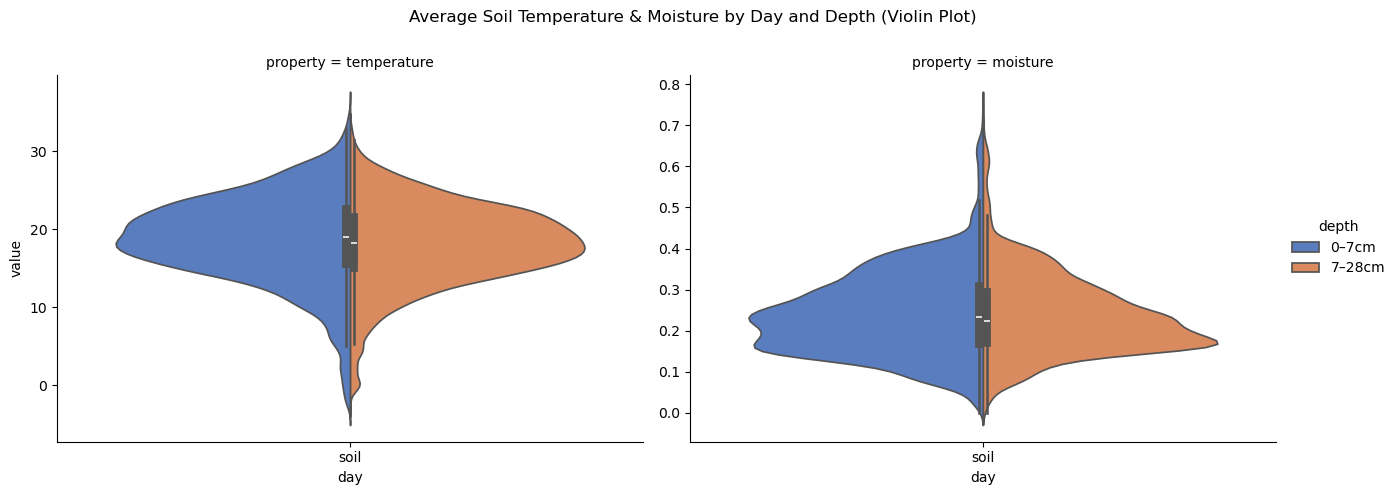

In [16]:
# Select columns which have soil depth
depth_cols = [col for col in dayof.columns.values.tolist() if 'cm' in col]
mean_cols = [col for col in depth_cols if 'mean' in col]

# Melt to long format
melted = dayof[mean_cols].melt(var_name='feature', value_name='value')

# Extract structured metadata
melted['depth'] = melted['feature'].apply(lambda x: '0–7cm' if '0_to_7cm' in x else '7–28cm')
melted['property'] = melted['feature'].apply(lambda x: 'moisture' if 'moisture' in x else 'temperature')
melted['day'] = melted['feature'].apply(lambda x: x.split('_')[0])  # e.g. d0, d3, etc.

# Plot violin plots
g = sns.catplot(
    data=melted,
    x='day', y='value', hue='depth',
    col='property',
    kind='violin',
    split=True,
    height=5, aspect=1.3,
    sharey=False,
    palette='muted'
)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Average Soil Temperature & Moisture by Day and Depth (Violin Plot)")

plt.show()

In [18]:
weather_to_keep = ['temperature_2m_max', 
                  #  'temperature_2m_min', 

                  #  'precipitation_sum', 
                   'rain_sum', 
                  #  'sunshine_duration', 
                   'daylight_duration',

                  #  'wind_speed_10m_max', 
                   'wind_gusts_10m_max',
                   
                  #  'shortwave_radiation_sum', 
                   'et0_fao_evapotranspiration', 
                   'date', 'point_id', 'survey_date', 

                  #  'relative_humidity_2m_mean', 
                   'relative_humidity_2m_min', 'relative_humidity_2m_max',

                  #  'cloud_cover_mean', 
                   'cloud_cover_min', 'cloud_cover_max',

                #    'soil_temperature_0_to_7cm_max', 
                   'soil_temperature_7_to_28cm_max',
                #    'soil_temperature_0_to_7cm_mean', 'soil_temperature_0_to_7cm_min',
                #    'soil_temperature_7_to_28cm_mean', 'soil_temperature_7_to_28cm_min',

                   'soil_moisture_0_to_7cm_mean', 
                #    'soil_moisture_0_to_7cm_min', 'soil_moisture_0_to_7cm_max', 
                #    'soil_moisture_7_to_28cm_mean',
                #    'soil_moisture_7_to_28cm_min', 'soil_moisture_7_to_28cm_max'
                   ]

drop = ['soil_temperature_0_to_7cm_mean', 'soil_temperature_0_to_7cm_min',
        'soil_temperature_7_to_28cm_mean', 'soil_temperature_7_to_28cm_min',
        'soil_temperature_0_to_7cm_max',
        'soil_moisture_0_to_7cm_min', 'soil_moisture_0_to_7cm_max',
        'soil_moisture_7_to_28cm_mean',
        'soil_moisture_7_to_28cm_min', 'soil_moisture_7_to_28cm_max',
        'temperature_2m_min',
        'relative_humidity_2m_mean',
        'cloud_cover_mean', 
        'shortwave_radiation_sum', 'sunshine_duration',
        'precipitation_sum',
        'wind_speed_10m_max'
        ]
dayof = dayof.drop(columns=drop, errors='ignore')

In [19]:
agg_cols = ['rain_sum', 'wind_gusts_10m_max', 'cloud_cover_min', 'cloud_cover_max',]

## Aggregate by Weeks Before

In [21]:
# Create an aggregation dictionary for features, to find the min, max, mean and sum over different time windows
group_cols = ['point_id', 'survey_date']

mean_features = ['soil_moisture_0_to_7cm_mean']
min_features = ['cloud_cover_min', 'relative_humidity_2m_min']
max_features = ['soil_temperature_7_to_28cm_max', 'cloud_cover_max', 'relative_humidity_2m_max', 'wind_gusts_10m_max', 'temperature_2m_max']
sum_features = ['rain_sum', 'daylight_duration', 'et0_fao_evapotranspiration']

agg_type = {'mean': mean_features,
            'min': min_features,
            'max': max_features,
            'sum': sum_features}

agg_dict = {}

for key, feature_list in agg_type.items():
    agg_dict.update({col: key for col in feature_list})

In [22]:
def aggregate_over_windows(df, windows=[0,7,14,21,28], window_size=7):
    df['date'] = pd.to_datetime(df['date'])
    df['survey_date'] = pd.to_datetime(df['survey_date'])
    df['days_diff'] = (df['survey_date'] - df['date']).dt.days

    all_agg_rows = pd.DataFrame()
    all_agg_rows[['point_id', 'survey_date']] = df[['point_id', 'survey_date']].drop_duplicates()    

    for window in windows:
        window_df = df.loc[(df['days_diff'] > window - window_size) & (df['days_diff'] <= window)]
        window_df = window_df.groupby(group_cols, as_index=False).agg(agg_dict)
        week = int(window/7)
        column_list = window_df.columns.drop(['point_id', 'survey_date'])
        window_df.columns = [f"w{week}_{agg_dict[col]}_{col}" if col in column_list else col for col in window_df.columns]
        all_agg_rows = all_agg_rows.merge(window_df, on=['point_id', 'survey_date'])

    return all_agg_rows

output_df = aggregate_over_windows(merged)

In [23]:
# ALTERNATIVE: Aggregate by Mean of all
agg_type = {'mean': mean_features + min_features + max_features + sum_features}

agg_dict = {}

for key, feature_list in agg_type.items():
    agg_dict.update({col: key for col in feature_list})

mean_agg_df = aggregate_over_windows(merged)

mean_agg_df = mean_agg_df.merge(soil, how='inner', on=['point_id', 'survey_date'])

In [24]:
# ALTERNATIVE: Aggregate by Mean of all
agg_type = {'mean': mean_features + min_features + max_features + sum_features}

agg_dict = {}

for key, feature_list in agg_type.items():
    agg_dict.update({col: key for col in feature_list})

mean_agg_fortnight_df = aggregate_over_windows(merged, windows=[0,14,28], window_size=14)

mean_agg_fortnight_df = mean_agg_fortnight_df.merge(soil, how='inner', on=['point_id', 'survey_date'])

In [25]:
agg_df = output_df.merge(soil, how='inner', on=['point_id', 'survey_date'])


⚠️ High correlation in 'mean_soil_moisture_0_to_7cm_mean':


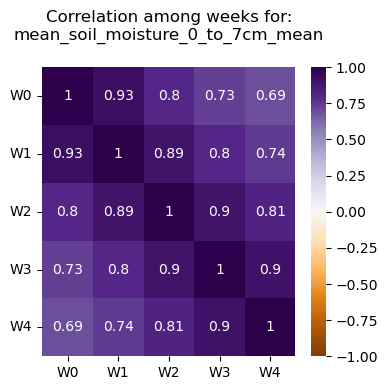


Not as high correlation in 'min_cloud_cover_min':


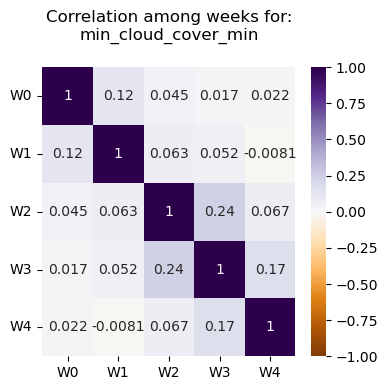


Not as high correlation in 'min_relative_humidity_2m_min':


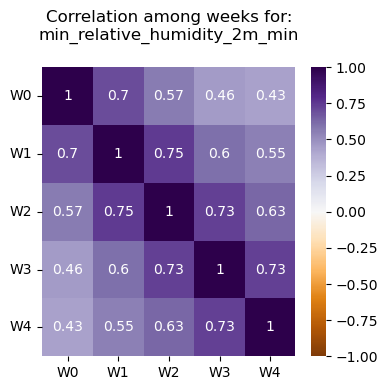


⚠️ High correlation in 'max_soil_temperature_7_to_28cm_max':


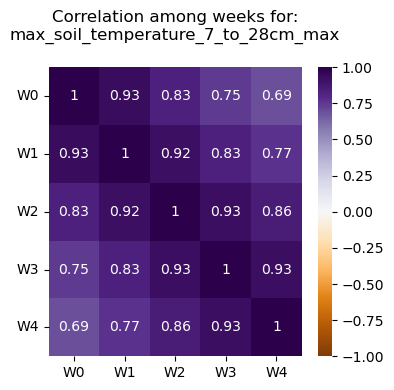


Not as high correlation in 'max_cloud_cover_max':


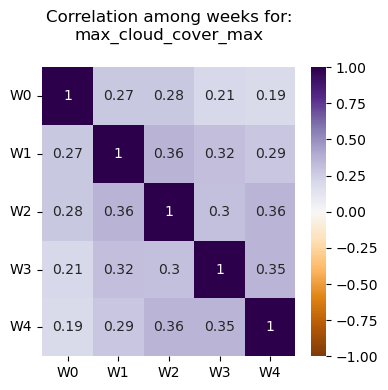


Not as high correlation in 'max_relative_humidity_2m_max':


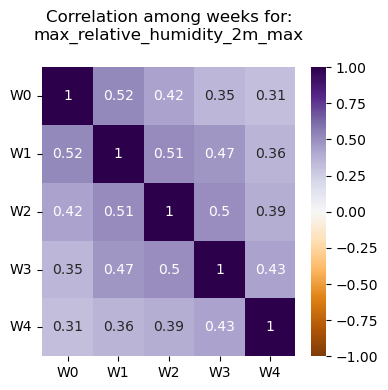


Not as high correlation in 'max_wind_gusts_10m_max':


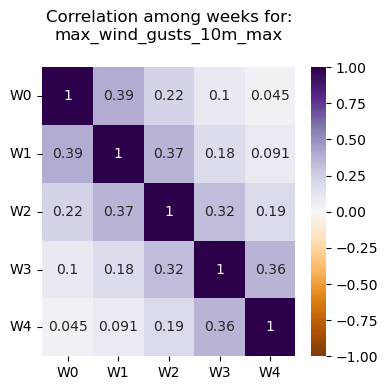


Not as high correlation in 'max_temperature_2m_max':


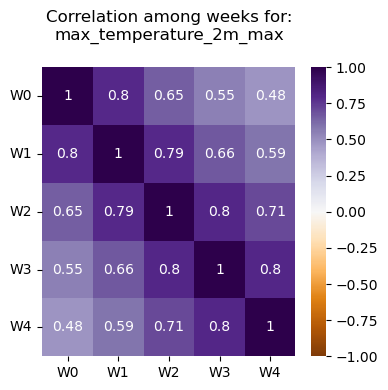


Not as high correlation in 'sum_rain_sum':


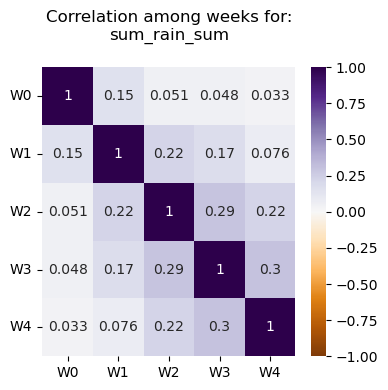


⚠️ High correlation in 'sum_daylight_duration':


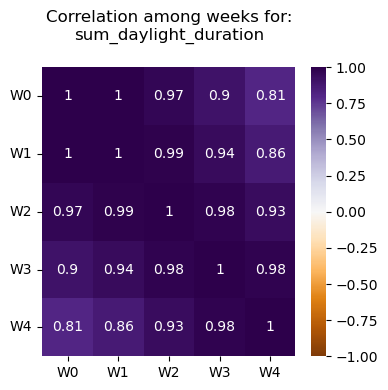


Not as high correlation in 'sum_et0_fao_evapotranspiration':


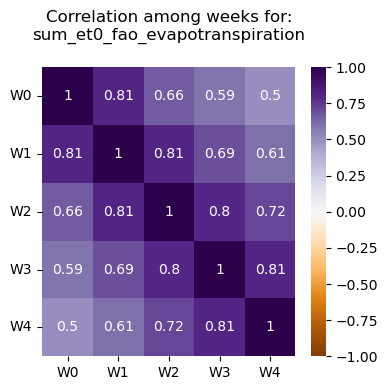

In [32]:
def check_weekly_collinearity(df, threshold=0.9, annotation=''):
    # Get all base feature names (stripping week identifiers)
    base_features = {}

    # Group columns by base name (excluding week prefix)
    for col in df.columns:
        if col.startswith('w') and '_' in col:
            parts = col.split('_', 1)
            if len(parts) == 2:
                week, base = parts
                base_features.setdefault(base, []).append(col)

    for base, cols in base_features.items():
        if len(cols) > 1:
            data = df[cols].copy()
            # Rename to W0, W1, etc. for cleaner heatmap
            data.columns = [col.split('_')[0].upper() for col in cols]

            corr = data.corr()
            high_corr = (corr.abs() > threshold) & (corr.abs() < 1)

            if high_corr.any().any():
                print(f"\n⚠️ High correlation in '{base}':")
                plt.figure(figsize=(4, 4))
                sns.heatmap(corr, annot=True, cmap='PuOr', vmin=-1, vmax=1)
                plt.title(f"Correlation among weeks for:\n{base}", pad=20)
                plt.yticks(rotation=0)
                plt.tight_layout()
                plt.savefig(f"../graphs/weather/corrmap_{annotation}_{base}.png", dpi=300)
                plt.show()
            else:
                print(f"\nNot as high correlation in '{base}':")
                plt.figure(figsize=(4, 4))
                sns.heatmap(corr, annot=True, cmap='PuOr', vmin=-1, vmax=1)
                plt.title(f"Correlation among weeks for:\n{base}", pad=20)
                plt.yticks(rotation=0)
                plt.tight_layout()
                plt.savefig(f"../graphs/weather/corrmap_{annotation}_{base}.png", dpi=300)
                plt.show()

check_weekly_collinearity(agg_df, annotation='minmaxsummean_weekly')


Not as high correlation in 'mean_soil_moisture_0_to_7cm_mean':


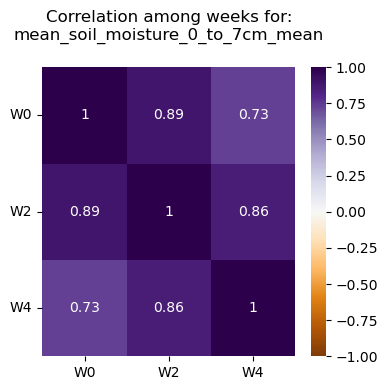


Not as high correlation in 'mean_cloud_cover_min':


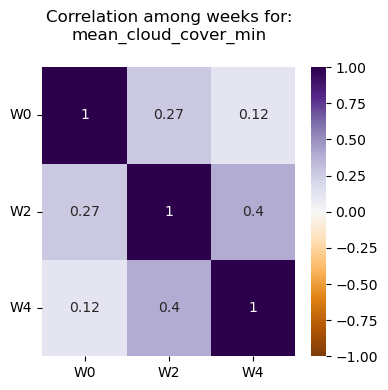


Not as high correlation in 'mean_relative_humidity_2m_min':


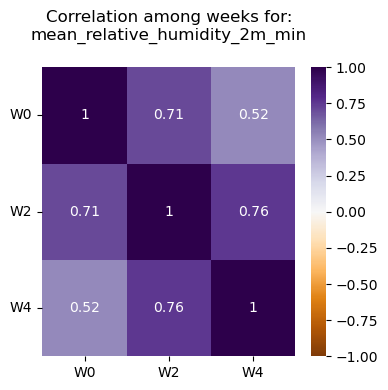


⚠️ High correlation in 'mean_soil_temperature_7_to_28cm_max':


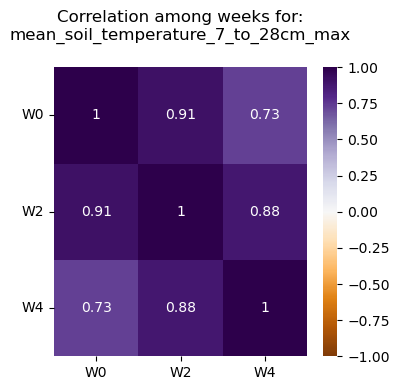


Not as high correlation in 'mean_cloud_cover_max':


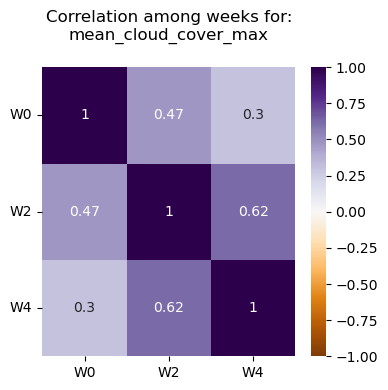


Not as high correlation in 'mean_relative_humidity_2m_max':


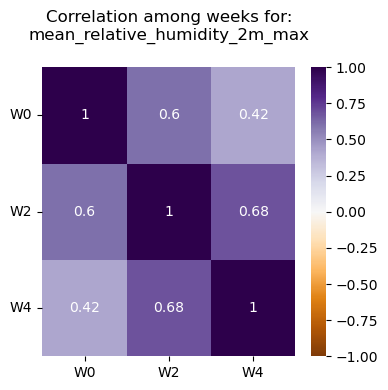


Not as high correlation in 'mean_wind_gusts_10m_max':


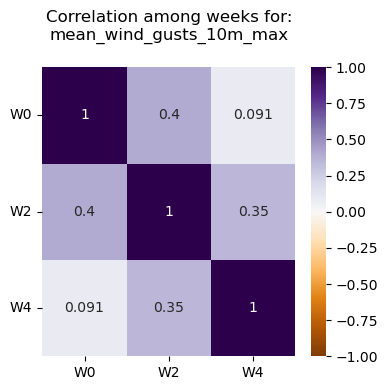


Not as high correlation in 'mean_temperature_2m_max':


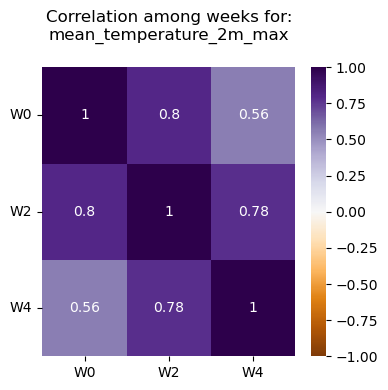


Not as high correlation in 'mean_rain_sum':


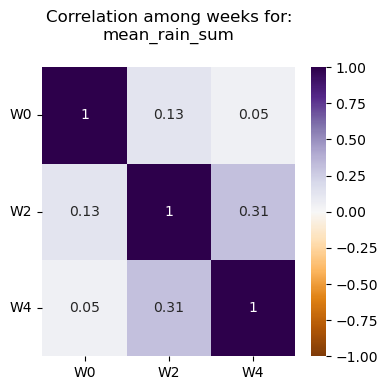


⚠️ High correlation in 'mean_daylight_duration':


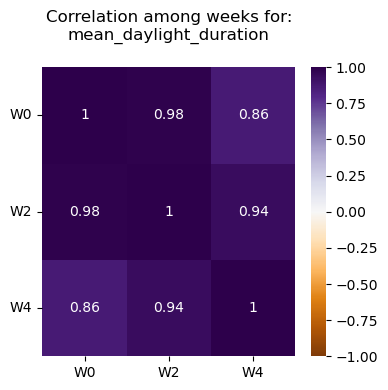


Not as high correlation in 'mean_et0_fao_evapotranspiration':


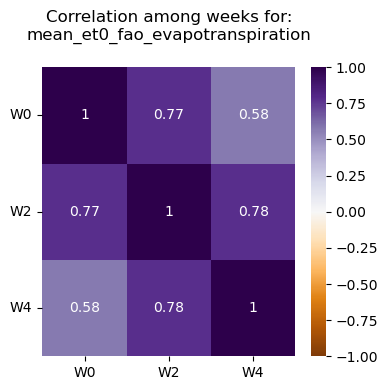

In [33]:
check_weekly_collinearity(mean_agg_fortnight_df, annotation="fortnight_mean_agg")


⚠️ High correlation in 'mean_soil_moisture_0_to_7cm_mean':


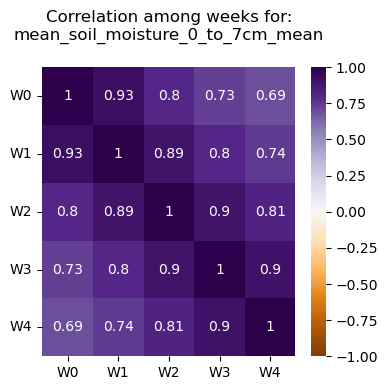


Not as high correlation in 'mean_cloud_cover_min':


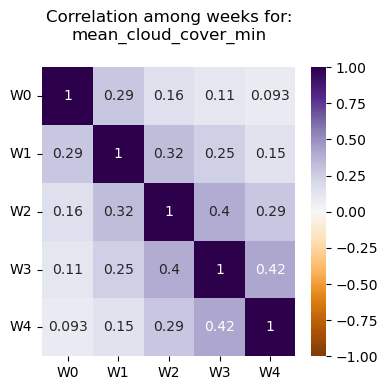


Not as high correlation in 'mean_relative_humidity_2m_min':


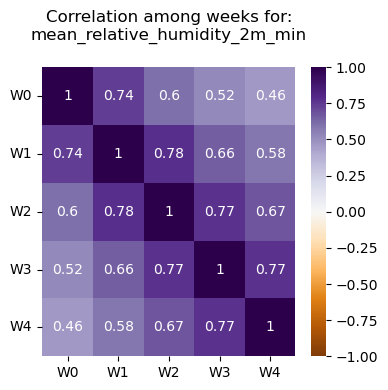


⚠️ High correlation in 'mean_soil_temperature_7_to_28cm_max':


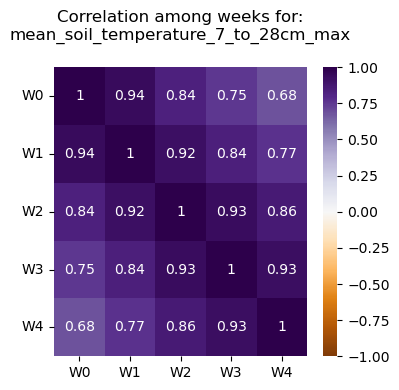


Not as high correlation in 'mean_cloud_cover_max':


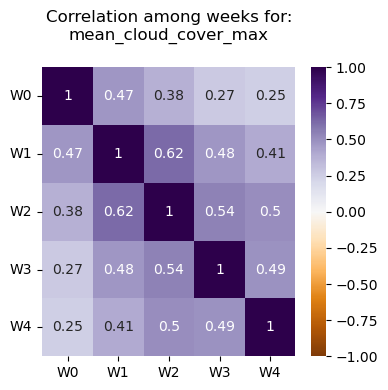


Not as high correlation in 'mean_relative_humidity_2m_max':


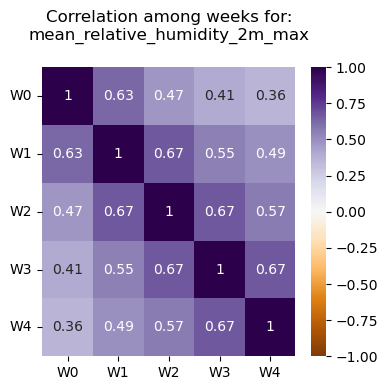


Not as high correlation in 'mean_wind_gusts_10m_max':


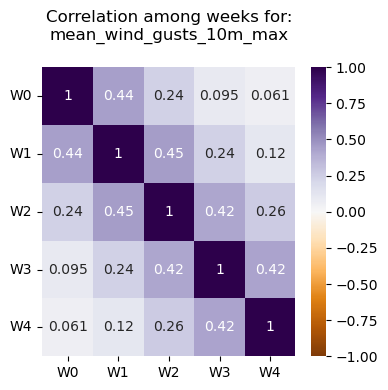


Not as high correlation in 'mean_temperature_2m_max':


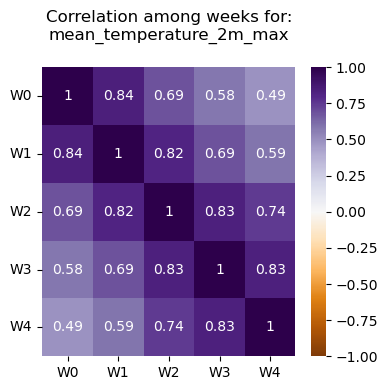


Not as high correlation in 'mean_rain_sum':


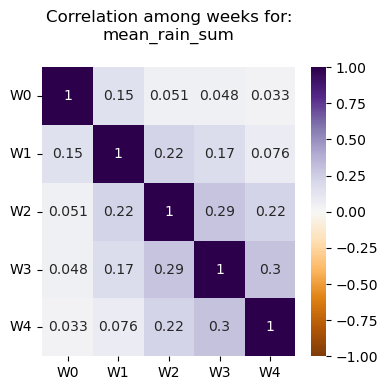


⚠️ High correlation in 'mean_daylight_duration':


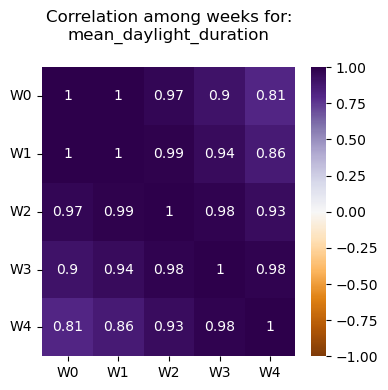


Not as high correlation in 'mean_et0_fao_evapotranspiration':


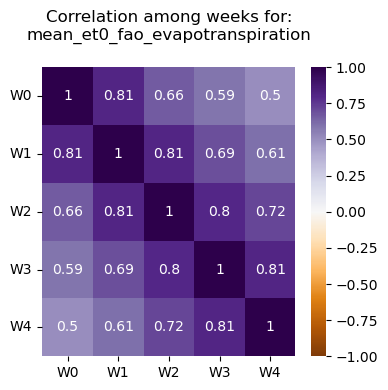

In [34]:
check_weekly_collinearity(mean_agg_df, annotation="weekly_mean_agg")

# Save as CSV

In [9]:
csv_filename = "./data/modelling/baseline_datasets/processed/250710_openmeteo_daily.csv"
merged.to_csv(csv_filename)

In [10]:
print(f"Number of rows from openmeteo: {len(merged)}")

Number of rows from openmeteo: 558388
